In [2]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import prepare

Split data (train/test) and resample by any period, except daily, and aggregate using the sum.\
Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:\
Simple Average\
Moving Average\
Holt's Linear Trend Model\
Based on previous year/month/etc., this is up to you.

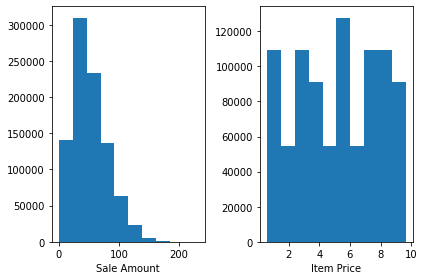

In [3]:
df = prepare.prepare_store_data()

In [4]:
df.head(2)

,item_id,sale_amount,sale_id,store_id,store_address,store_city,store_state,store_zipcode,item_brand,item_name,item_price,item_upc12,item_upc14,day_of_week,month,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,13.0,1,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,Tuesday,1,10.92
2013-01-01 00:00:00+00:00,12,26.0,211817,7,12018 Perrin Beitel Rd,San Antonio,TX,78217,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,Tuesday,1,218.40


In [7]:
forecast_df = df[['sale_amount', 'sales_total']].rename(columns = {'sales_amount':'items_sold', 'sales_total':'dollars_sold'})

In [9]:
forecast_df = forecast_df.resample('D').sum()

In [10]:
forecast_df

,sale_amount,dollars_sold
sale_date,,
2013-01-01 00:00:00+00:00,13696.0,73844.01
2013-01-02 00:00:00+00:00,13678.0,73570.58
2013-01-03 00:00:00+00:00,14488.0,78169.48
2013-01-04 00:00:00+00:00,15677.0,84467.73
2013-01-05 00:00:00+00:00,16237.0,87621.85
...,...,...
2017-12-27 00:00:00+00:00,20378.0,109151.15
2017-12-28 00:00:00+00:00,21885.0,117377.49
2017-12-29 00:00:00+00:00,23535.0,126541.84


In [14]:
train_prop = 0.66
train_size = int(len(forecast_df) * train_prop)
train, test = forecast_df[0:train_size], forecast_df[train_size:len(forecast_df)]

In [16]:
train.shape, test.shape

((1205, 2), (621, 2))

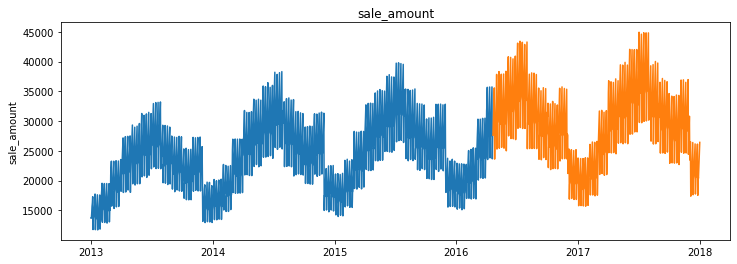

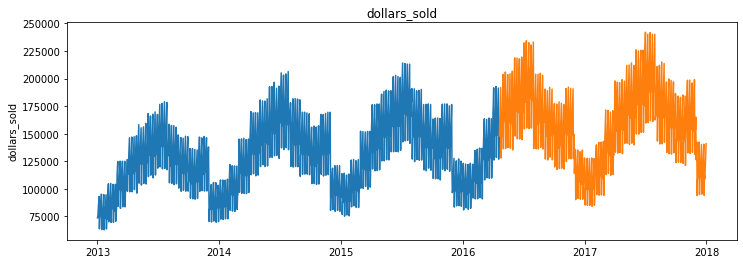

In [22]:
for cols in train.columns:
    plt.figure(figsize = (12,4))
    plt.plot(train[cols])
    plt.plot(test[cols])
    plt.ylabel(cols)
    plt.title(cols)
    plt.show()